The overall issue of modern portfolio theory: although the covariances of a few assets can be adequately estimated, it is difficult to come up with reasonable estimates of expected returns.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv

import sys
import os
sys.path.append(os.path.abspath("./"))

from quant.utils import get_factors, get_monthly_returns, get_stock_details, get_portfolio_weights, select_factor_list, visualize_returns
from quant.helpers import run_regression, compute_annual_return, get_insights, forecast_factors, compute_monthly_expected_returns

load_dotenv()

True

[*********************100%%**********************]  1 of 1 completed


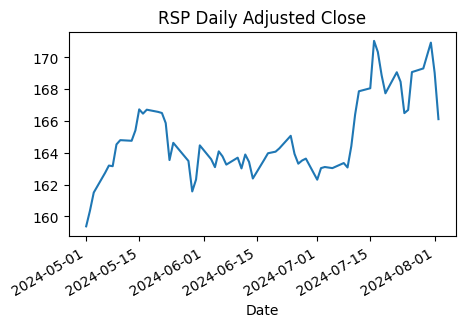

[*********************100%%**********************]  1 of 1 completed


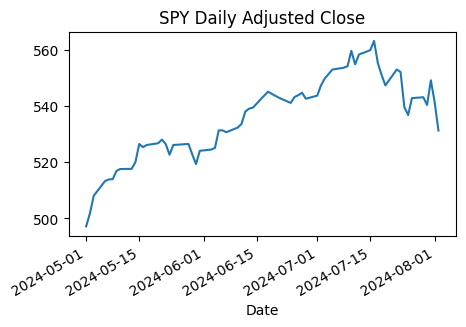

RSP Return 4.226839833139495
166.11680603027344 159.38006591796875
SPY Return 6.849037106761206
531.2704467773438 497.2159423828125
Open         1.682300e+02
High         1.684100e+02
Low          1.651000e+02
Close        1.667700e+02
Adj Close    1.661168e+02
Volume       1.166630e+07
Name: 2024-08-02 00:00:00, dtype: float64


NameError: name 'returns' is not defined

In [5]:
# As an example, we will use the stock of Apple Inc. (AAPL)
stock_name1 = "RSP"
returns1 = yf.download(f"{stock_name1}", start="2024-05-01", end="2024-08-03")
returns1["Adj Close"].plot(title=f"{stock_name1} Daily Adjusted Close", figsize=(5, 3))
plt.show()

stock_name2 = "SPY"
returns2 = yf.download(f"{stock_name2}", start="2024-05-01", end="2024-08-03")
returns2["Adj Close"].plot(title=f"{stock_name2} Daily Adjusted Close", figsize=(5, 3))
plt.show()

# returns1["Adj Close"].pct_change().plot(title=f"{stock_name1} Daily Returns", figsize=(8, 3))
# plt.show()

# returns2["Adj Close"].pct_change().plot(title=f"{stock_name2} Daily Returns", figsize=(8, 3))
# plt.show()

print(f"{stock_name1} Return", (returns1['Adj Close'].iloc[-1] - returns1['Adj Close'].iloc[0]) / returns1['Adj Close'].iloc[0] * 100)
print(returns1['Adj Close'].iloc[-1], returns1['Adj Close'].iloc[0])
print(f"{stock_name2} Return", (returns2['Adj Close'].iloc[-1] - returns2['Adj Close'].iloc[0]) / returns2['Adj Close'].iloc[0] * 100)
print(returns2['Adj Close'].iloc[-1], returns2['Adj Close'].iloc[0])

print(returns1.iloc[-1])

# calculate daily returns of QQQ
# data = returns["Adj Close"].to_frame()
# data["Return"] = data["Adj Close"].pct_change() * 100
# data.dropna(inplace=True)
# data

data = returns["Adj Close"].resample("ME").ffill().to_frame()
data.index = data.index.to_period("M")
data["Return"] = data["Adj Close"].pct_change() * 100
data.dropna(inplace=True)
data

We want to explain our portfolio, or single stock, using factors defined by the a series of linear models that relates the expected return of a stock to several historical factors of the market. The most simple of these is the CAPM model, which aims to relate the expected return of an asset to the the expected return of the market. The model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f)
$$

Where:
- $E[R_i]$ is the expected return of the stock
- $R_f$ is the risk-free rate
- $\beta_i$ is the beta of the stock
- $E[R_m]$ is the expected return of the market

The beta of a stock is a measure of the stock's volatility in relation to the market. A beta of 1 means that the stock moves in line with the market. A beta greater than 1 means that the stock is more volatile than the market, and a beta less than 1 means that the stock is less volatile than the market.

In our case, we will grab the market excess returns from the Kenneth French data library.

This same model is used extended by the Fama-French 3 factor model, which adds two more factors to the model. The Fama-French model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML
$$

Where:
- $s_i$ is the stock's exposure to the size factor
- $SMB$ is the size factor, which measures the difference in returns between small and large cap stocks over the specified period
- $h_i$ is the stock's exposure to the value factor
- $HML$ is the value factor, which measures the difference in returns between value and growth stocks over the specified period, considering its book-to-market ratio

This model can be extended further to the Fama-French 5 factor model, which adds two more factors to the model. The Fama-French 5 factor model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML + r_i RMW + c_i CMA
$$

Where:
- $r_i$ is the stock's exposure to the profitability factor
- $RMW$ is the profitability factor, which measures the difference in returns between high (robust) and low (weak) profitability stocks over the specified period, based on their earnings
- $c_i$ is the stock's exposure to the investment factor
- $CMA$ is the investment factor, which measures the difference in returns between stocks that reinvest a lower amount (conservative) versus a higher amount (aggressive) over the specified period

In [2]:
# tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "PYPL", "ADBE", "NFLX"]
tickers = ["AAPL", 'NVDA', "MSFT", "GOOGL", "AMZN", 'META', "TSLA"]
# tickers = ["AMD", "INTC", "QCOM", "IBM", "PINS", "AAPL", "GOOGL"]
# include 100 different small cap stocks
# tickers = 
initial_amount = 10000
start_date = "2012-01-10"
end_date = "2024-11-19"
strategy = "rpp"
model_type = "ff5" # Either capm, ff3, or ff5

In [3]:
portfolio = get_monthly_returns(tickers, start_date, end_date)
factors_monthly = get_factors()
factor_list = select_factor_list(model_type)
factors_subset = factors_monthly[factors_monthly.index.isin(portfolio.index)].copy()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
weights = get_portfolio_weights(tickers, strategy=strategy, start_date=start_date, end_date=end_date, l=5, rf=factors_subset["RF"].mean())
# We will also take the data of a portfolio with weights
portfolio_return = (portfolio * weights).sum(axis=1)

factors_subset["Excess Returns"] = portfolio_return - factors_subset["RF"]

if len(tickers) != len(weights):
    raise ValueError("Number of tickers and weights must be equal")

[*********************100%%**********************]  7 of 7 completed

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.371009829710196e-20
            Iterations: 64
            Function evaluations: 512
            Gradient evaluations: 64


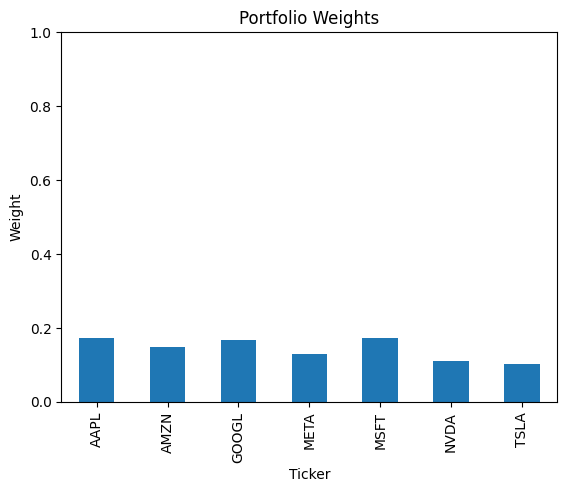

In [5]:
from matplotlib import pyplot as plt
weights.plot(kind='bar')
plt.title('Portfolio Weights')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.show()


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

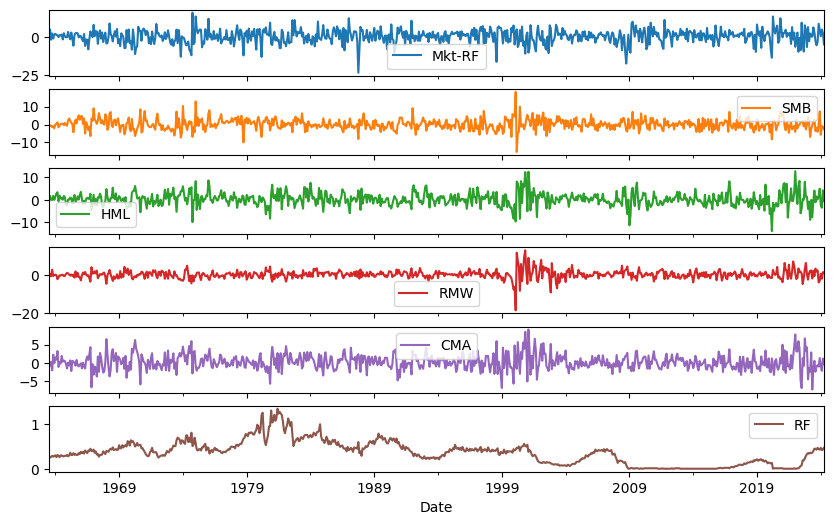

In [6]:
# Plot factors across time
factors_monthly.plot(subplots=True, figsize=(10, 6))

<Axes: title={'center': 'Portfolio Monthly Returns'}, xlabel='Date'>

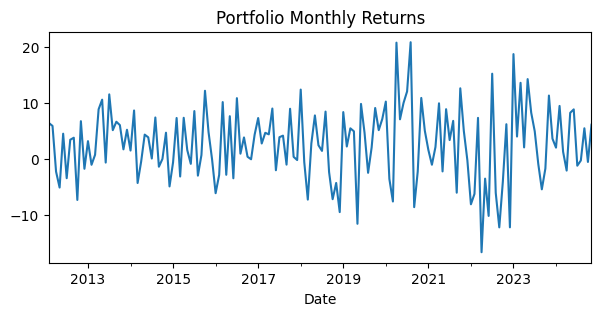

In [7]:
# Plot portfolio returns
portfolio_return.plot(title="Portfolio Monthly Returns", figsize=(7, 3))

In [8]:
# X = sm.add_constant(factors_subset[["Mkt-RF"]]) # CAPM model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML"]]) # Fama-French 3-factor model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]) # Fama-French 5-factor model
# y = factors_subset["Excess Returns"]
# model = sm.OLS(y, X).fit()
# model.summary()
model = run_regression(factors_subset, factor_list)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     94.90
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.36e-43
Time:                        14:51:05   Log-Likelihood:                -377.97
No. Observations:                 147   AIC:                             767.9
Df Residuals:                     141   BIC:                             785.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2411      0.279      4.451      0.000       0.690       1.792
Mkt-RF         1.2284      0.068     17.962      0.000       1.093       1.364
SMB           -0.3709      0.125     -2.960      0.004      -0.619      -0.123
HML           -0.3187      0.112     -2.845      0.005      -0.540      -0.097
RMW           -0.0740      0.154     -0.482      0.631      -0.377       0.230
CMA           -0.6414      0.170     -3.770      0.000      -0.978      -0.305
==============================================================================
Omnibus:                        0.321   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.425
Skew:                           0.104   Prob(JB):                        0.809
Kurtosis:                       2.838   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have built our regression model, we can visualize how each coefficient affects the expected return of the stock.

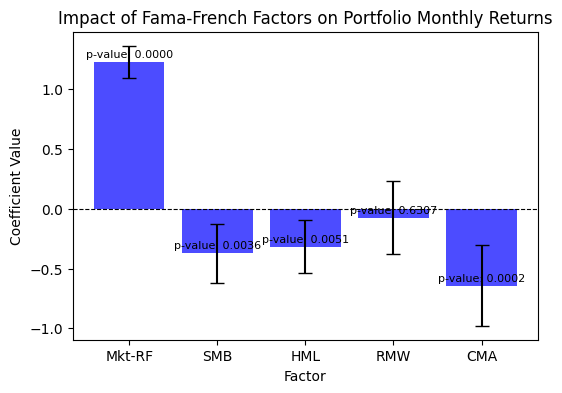

In [9]:
# Extract the coefficients and confidence intervals
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().iloc[1:]

ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Confidence_Lower": confidence_intervals[0],
    "Confidence_Upper": confidence_intervals[1],
    "P-Value": model.pvalues[1:]
})

# Plotting for visual confirmation
plt.figure(figsize=(6, 4))

bars = plt.bar(ols_data["Factor"], ols_data["Coefficient"], color='blue', alpha=0.7, capsize=10)
plt.errorbar(
    ols_data["Factor"],
    ols_data["Coefficient"],
    yerr=[
        ols_data["Coefficient"] - ols_data["Confidence_Lower"],
        ols_data["Confidence_Upper"] - ols_data["Coefficient"]
    ],
    fmt='none',
    capsize=5,
    color='black'
)

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'] + 0.02,  # Position text slightly above the bar
        f"p-value: {row['P-Value']:.4f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.title("Impact of Fama-French Factors on Portfolio Monthly Returns")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()

In [139]:
client = OpenAI()

# Analyze the OLS regression results using GPT-4
stock_details = get_stock_details(tickers)
insights = get_insights(client, ols_data, portfolio=portfolio_return, stock_details=stock_details, advanced=False)
print("Insights from GPT-4o:\n", insights)

KeyboardInterrupt: 

In [181]:
# Example usage
forecasted_factors = forecast_factors(factors_monthly, model_type=model_type, steps=12)
monthly_expected_returns = compute_monthly_expected_returns(model, forecasted_factors)
annual_expected_return = compute_annual_return(monthly_expected_returns)

# print(monthly_expected_returns)
print("Expected Annual Return for the Next 12 Months: {:.2f}%".format(annual_expected_return * 100))


Expected Annual Return for the Next 12 Months: 9.26%


[7.981385668618869, -4.099312691676286, 4.290938072233062, 5.187877465254133, 3.173073397263527, 0.07177254504995467, 3.540080091882429, -3.836849122483855, 1.3984000390415052, 0.8102487211638064, 0.16624703266881063, -3.3753287078766094, 2.110991831459946]


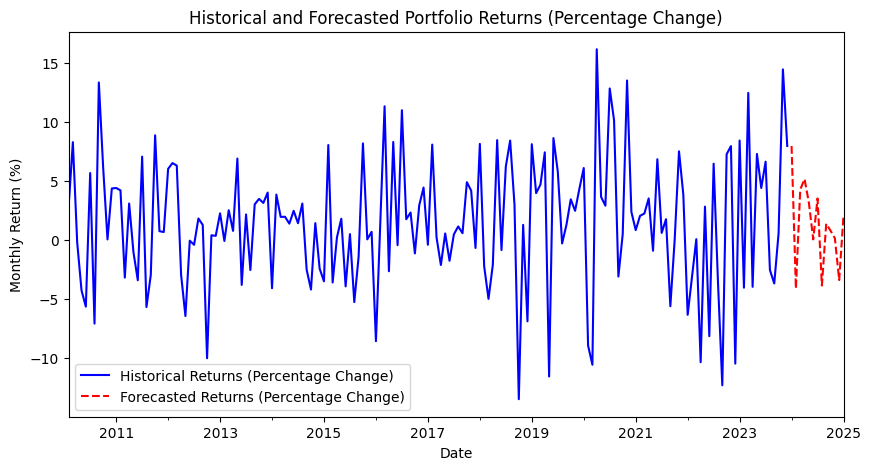

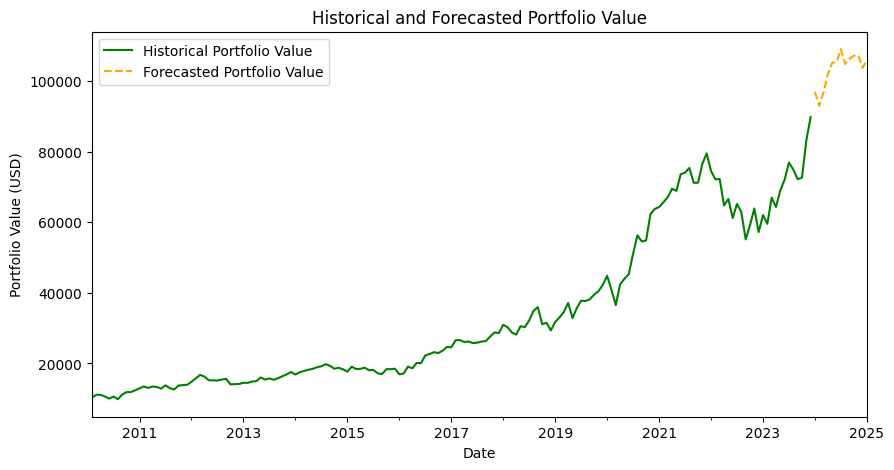

In [182]:
portfolio_return = (portfolio * weights).sum(axis=1)
# print(portfolio, weights)
visualize_returns(portfolio_return, monthly_expected_returns, initial_amount)

## Future Directions
- We can extend this model to include more factors (e.g. momentum, quality, etc.). Can also extend model to include macroeconomic factors.
- Portfolio allocation via deep-learning model
- Mix markowitz portfolio allocation with risk parity allocation (adjust how much risk you want to take)